## S4_feature_conbined

In [8]:
import warnings; warnings.simplefilter("ignore")

import gc
import pandas as pd
from tqdm import tqdm

from utils import *

In [9]:
def pad_target(x): # ここに渡すoof, subはgroupby("customer_ID")もしてない(->customer_IDによって1~13レコード、数がバラバラ) --
    t = np.zeros(13)
    t[:-len(x)] = np.nan
    t[-len(x):] = x
    return list(t)

In [10]:
oof = pd.read_csv("./output/LGB_with_series_feature/oof.csv")
sub = pd.read_csv("./output/LGB_with_series_feature/submission.csv")

tmp1 = oof.groupby("customer_ID", sort=False)["target"].agg(lambda x: pad_target(x))
tmp2 = sub.groupby("customer_ID", sort=False)["prediction"].agg(lambda x: pad_target(x))

tmp = tmp1.append(tmp2)
tmp = pd.DataFrame(data=tmp.tolist(), columns=["target%s"%i for i in range(1, 14)])

In [11]:
del oof, sub, tmp1, tmp2; gc.collect()

0

In [12]:
def GreedyFindBin(distinct_values, counts,num_distinct_values, max_bin, total_cnt, min_data_in_bin=3):
#INPUT:
#   distinct_values 保存特征取值的数组，特征取值单调递增
#   counts 特征的取值对应的样本数目
#   num_distinct_values 特征取值的数量
#   max_bin 分桶的最大数量
#   total_cnt 样本数量
#   min_data_in_bin 桶包含的最小样本数

# bin_upper_bound就是记录桶分界的数组
    bin_upper_bound=list();
    assert(max_bin>0)

    # 特征取值数比max_bin数量少，直接取distinct_values的中点放置
    if num_distinct_values <= max_bin:
        cur_cnt_inbin = 0
        for i in range(num_distinct_values-1):
            cur_cnt_inbin += counts[i]
            #若一个特征的取值比min_data_in_bin小，则累积下一个取值，直到比min_data_in_bin大，进入循环。
            if cur_cnt_inbin >= min_data_in_bin:
                #取当前值和下一个值的均值作为该桶的分界点bin_upper_bound
                bin_upper_bound.append((distinct_values[i] + distinct_values[i + 1]) / 2.0)
                cur_cnt_inbin = 0
        # 对于最后一个桶的上界则为无穷大
        cur_cnt_inbin += counts[num_distinct_values - 1];
        bin_upper_bound.append(float('Inf'))
        # 特征取值数比max_bin来得大，说明几个特征值要共用一个bin
    else:
        if min_data_in_bin>0:
            max_bin=min(max_bin,total_cnt//min_data_in_bin)
            max_bin=max(max_bin,1)
        #mean size for one bin
        mean_bin_size=total_cnt/max_bin
        rest_bin_cnt = max_bin
        rest_sample_cnt = total_cnt
        #定义is_big_count_value数组：初始设定特征每一个不同的值的数量都小（false）
        is_big_count_value=[False]*num_distinct_values
        #如果一个特征值的数目比mean_bin_size大，那么这些特征需要单独一个bin
        for i in range(num_distinct_values):
        #如果一个特征值的数目比mean_bin_size大，则设定这个特征值对应的is_big_count_value为真。。
            if counts[i] >= mean_bin_size:
                is_big_count_value[i] = True
                rest_bin_cnt-=1
                rest_sample_cnt -= counts[i]
        #剩下的特征取值的样本数平均每个剩下的bin：mean size for one bin
        mean_bin_size = rest_sample_cnt/rest_bin_cnt
        upper_bounds=[float('Inf')]*max_bin
        lower_bounds=[float('Inf')]*max_bin

        bin_cnt = 0
        lower_bounds[bin_cnt] = distinct_values[0]
        cur_cnt_inbin = 0
        #重新遍历所有的特征值（包括数目大和数目小的）
        for i in range(num_distinct_values-1):
            #如果当前的特征值数目是小的
            if not is_big_count_value[i]:
                rest_sample_cnt -= counts[i]
            cur_cnt_inbin += counts[i]

            # 若cur_cnt_inbin太少，则累积下一个取值，直到满足条件，进入循环。
            # need a new bin 当前的特征如果是需要单独成一个bin，或者当前几个特征计数超过了mean_bin_size，或者下一个是需要独立成桶的
            if is_big_count_value[i] or cur_cnt_inbin >= mean_bin_size or \
            is_big_count_value[i + 1] and cur_cnt_inbin >= max(1.0, mean_bin_size * 0.5):
                upper_bounds[bin_cnt] = distinct_values[i] # 第i个bin的最大就是 distinct_values[i]了
                bin_cnt+=1
                lower_bounds[bin_cnt] = distinct_values[i + 1] # 下一个bin的最小就是distinct_values[i + 1]，注意先++bin了
                if bin_cnt >= max_bin - 1:
                    break
                cur_cnt_inbin = 0
                if not is_big_count_value[i]:
                    rest_bin_cnt-=1
                    mean_bin_size = rest_sample_cnt / rest_bin_cnt
#             bin_cnt+=1
        # update bin upper bound 与特征取值数比max_bin数量少的操作类似，取当前值和下一个值的均值作为该桶的分界点
        for i in range(bin_cnt-1):
            bin_upper_bound.append((upper_bounds[i] + lower_bounds[i + 1]) / 2.0)
        bin_upper_bound.append(float('Inf'))
    return bin_upper_bound

In [13]:
cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
eps = 1e-3

In [14]:
dfs = []
for fn in ["cat", "num", "diff", "rank_num", "last3_cat", "last3_num", "last3_diff", "last6_num", "ym_rank_num"]:
    if len(dfs) == 0:
        dfs.append(pd.read_feather(f"./input/{fn}_feature.feather"))
    else:
        dfs.append(pd.read_feather(f"./input/{fn}_feature.feather").drop(["customer_ID"], axis=1))

    if "last" in fn:
        dfs[-1] = dfs[-1].add_prefix("_".join(fn.split("_")[:-1])+"_")

for df in dfs:
    for col in tqdm(df.columns):
        if col not in ['customer_ID','S_2']:
            # v_min = df[col].min()
            # v_max = df[col].max()
            # df[col] = (df[col]-v_min+eps) / (v_max-v_min+eps)
            vc = df[col].value_counts().sort_index()
            bins = GreedyFindBin(vc.index.values,vc.values,len(vc),255,vc.sum())
            df[col] = np.digitize(df[col],[-np.inf]+bins)
            df.loc[df[col]==len(bins)+1,col] = 0
            df[col] = df[col] / df[col].max()

    # rmu
    df = reduce_mem_usage(df)

100%|██████████| 208/208 [00:14<00:00, 14.45it/s]


Memory usage after optimization is: 594.33 MB
Decreased by 73.4%


100%|██████████| 1062/1062 [03:13<00:00,  5.49it/s]


Memory usage after optimization is: 2802.49 MB
Decreased by 75.0%


100%|██████████| 1062/1062 [02:34<00:00,  6.87it/s]


Memory usage after optimization is: 2802.49 MB
Decreased by 75.0%


100%|██████████| 177/177 [00:10<00:00, 16.50it/s]


Memory usage after optimization is: 467.08 MB
Decreased by 75.0%


100%|██████████| 150/150 [00:05<00:00, 26.85it/s]


Memory usage after optimization is: 395.83 MB
Decreased by 75.0%


100%|██████████| 885/885 [01:48<00:00,  8.17it/s]


Memory usage after optimization is: 2335.41 MB
Decreased by 75.0%


100%|██████████| 885/885 [02:12<00:00,  6.67it/s]


Memory usage after optimization is: 2335.41 MB
Decreased by 75.0%


100%|██████████| 885/885 [02:12<00:00,  6.70it/s]


Memory usage after optimization is: 2335.41 MB
Decreased by 75.0%


100%|██████████| 1062/1062 [04:41<00:00,  3.77it/s]


Memory usage after optimization is: 2802.49 MB
Decreased by 75.0%


In [15]:
tmp = tmp.fillna(0)
dfs.append(tmp)
df = pd.concat(dfs, axis=1)

In [16]:
df.to_feather("./input/nn_all_feature.feather")

In [21]:
vc = tmp["target1"].value_counts().sort_index()

tt = GreedyFindBin(vc.index.values, vc.values, len(vc), 255, vc.sum())

In [25]:
ttt = pd.DataFrame(tt)

<AxesSubplot: >

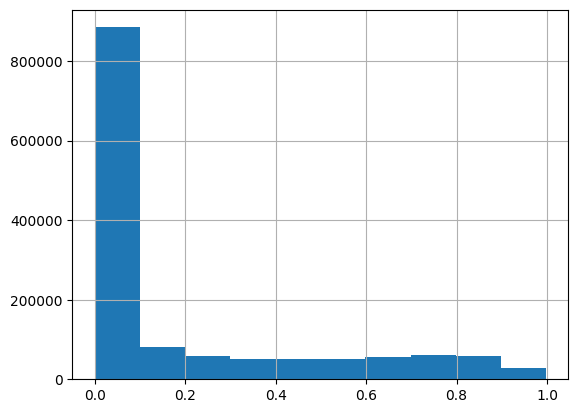

In [28]:
tmp["target1"].hist()

array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)

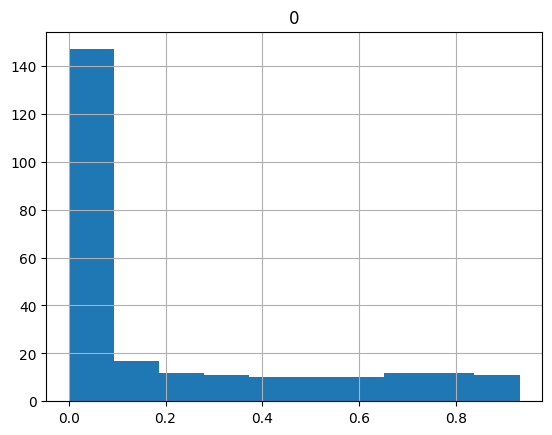

In [30]:
ttt.iloc[:252, :].hist()